In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [ ]:
BATCH_SIZE = 128
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
train_percent = 80
# hyperparameters
# müssen wir für batchnormalization auch den gamma und beta parameter anpassen?
LAMBDA = 0.01  # factor for l2
DROP = 0.1 # dropout rate

170500096/170498071 [==============================] - 4s 0us/step


(32, 32, 3)

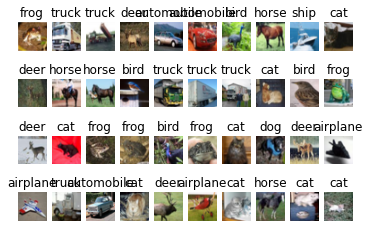

In [ ]:
train_dataset, test_dataset = tf.keras.datasets.cifar10.load_data()

train_images, train_labels = train_dataset
images_slice = train_images[0:40].reshape(4, 10, 32, 32, 3)
labels_slice = train_labels[0:40].reshape(4, 10, 1)
translate_labels = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}
fig, ax = plt.subplots(4, 10)

for i in range(4):
  for j in range(10):
    if j == 10:
      break
    ax[i, j].imshow(images_slice[i,j])
    ax[i, j].set_title(translate_labels[labels_slice[i,j][0]])
    ax[i, j].axis("off")
train_images[0].shape


In [ ]:
def normalize(image):
  image = image/255
  return image

def pipeline(data):
  data = tf.data.Dataset.from_tensor_slices(data)
  data = data.map(lambda image, label: (normalize(image), tf.one_hot(label, 10)))
  data = data.batch(BATCH_SIZE)
  data = data.shuffle(buffer_size=BATCH_SIZE)
  data = data.prefetch(PREFETCH_SIZE)
  return data

In [ ]:
# preprocess all data
processed_train_data = pipeline(train_dataset)
processed_test_data = pipeline(test_dataset)

In [ ]:
class ResidualBlock(tf.keras.layers.Layer): 
  
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()

    # define set of layers

    # be careful! with residual connections, you have to make sure that the dimensions from your input match the block output
    # therefore be careful what filter size youuse and choose sme padiing
    self.conv1 = tf.keras.layers.Conv2D(filters=channels, kernel_size=3, padding='SAME', activation=None)
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv2D(filters=channels, kernel_size=3, padding='SAME', activation=None)
    self.batchnorm2 = tf.keras.layers.BatchNormalization()

    self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME', activation=None)
    self.batchnorm3 = tf.keras.layers.BatchNormalization()
    self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME', activation=None)
    self.batchnorm4 = tf.keras.layers.BatchNormalization()

    self.conv5 = tf.keras.layers.Conv2D(filters=channels, kernel_size=3, padding='SAME', activation=None)
    self.batchnorm5 = tf.keras.layers.BatchNormalization()
   
    # you can put multiple more layers here
    self.relu = tf.keras.activations.relu

  def call(self, input, training_flag):

    # define call
    # add original input to block output
    
    x = self.conv1(input)
    x = self.batchnorm1(x, training_flag)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.batchnorm2(x, training_flag)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.batchnorm3(x, training_flag)
    x = self.relu(x)
    x = self.conv4(x)
    x = self.batchnorm4(x, training_flag)
    x = self.relu(x)
    x = self.conv5(x)
    x = self.batchnorm5(x, training_flag)
    output = self.relu(x)
    

    final_output = output + input

    return final_output

In [ ]:
# define network
class ResNet(tf.keras.Model):

  def __init__(self, num_blocks=2, channels_in_block=64): 

    super(ResNet, self).__init__()

    # you can define a set of layes to put in front of your custom blocks
    self.pre_block = [tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', activation=None)]
    self.pre_block.append(tf.keras.layers.BatchNormalization())
    self.pre_block.append(tf.keras.layers.ReLU())
    self.pre_block.append(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME', activation=None))
    self.pre_block.append(tf.keras.layers.BatchNormalization()) # muss ich bei batchnormalization nicht die activation function nochmal separat schreiben?
    self.pre_block.append(tf.keras.layers.ReLU())
 
    # now you can use your self defined blocks much like layers
    self.blocks = []
    for _ in range(num_blocks):
        self.blocks.append(ResidualBlock(channels=channels_in_block))
        #self.blocks.append(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='SAME'))
        # append more stuff if you want to alter the order in the call
        # eg Transition Layers
    
    # readout layers
    self.post_blocks = []
    self.post_blocks.append(tf.keras.layers.GlobalAveragePooling2D())
    self.post_blocks.append(tf.keras.layers.Dense(units=10, activation='softmax'))
   

    
  def call(self, x, training_flag=True):

      # pass input through pre_block layers
      # you can pass the training flag to every layer in tf
      for l in self.pre_block:
        x = l(x, training=training_flag)

      y = x
      for b in self.blocks:
        y = b(y, training_flag)
      
      # readout layers
      for b in self.post_blocks:
        y = b(y)

      # make sure prediction and target dimension match
      y = tf.expand_dims(y, axis=1)

      return y

In [ ]:
x = tf.ones((1, 32, 32, 3))
model_test = ResNet()
print(model_test(x))


tf.Tensor(
[[[0.01865618 0.04549402 0.02086838 0.00960064 0.10320646 0.02937849
   0.05334878 0.0993764  0.56938857 0.05068212]]], shape=(1, 1, 10), dtype=float32)


In [ ]:
# train step and test step functions
def train_step(model, input, target, loss_function, optimizer, training=True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

def visualize(train_losses, test_losses, test_accuracies):
  # visualize training progress
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("training","test"))
  plt.show()

  plt.figure()
  line1, = plt.plot(test_accuracies)
  plt.title(' max accuracy: '+ str(np.max(test_accuracies)))
  plt.xlabel("Training steps")
  plt.ylabel("Accuracy")
  #plt.set_ylim([0,1])
  plt.show()
  


Epoch: __ 0


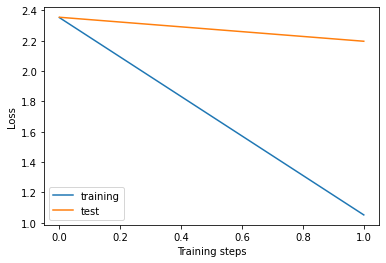

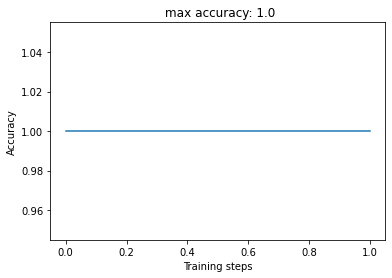

Epoch: __ 1


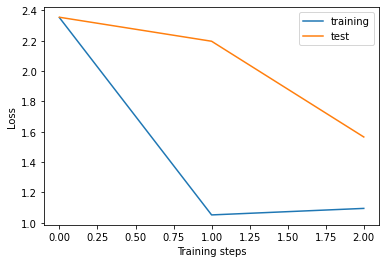

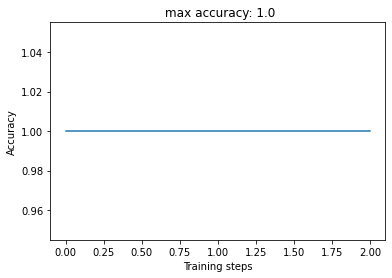

Epoch: __ 2


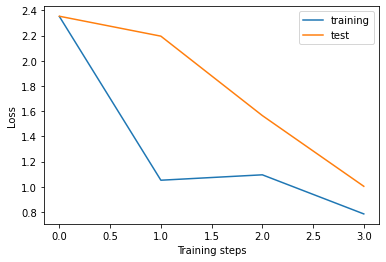

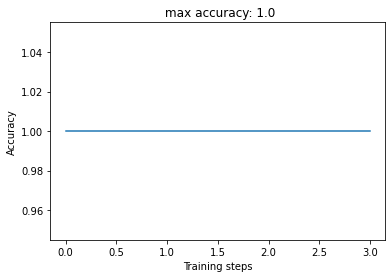

Epoch: __ 3


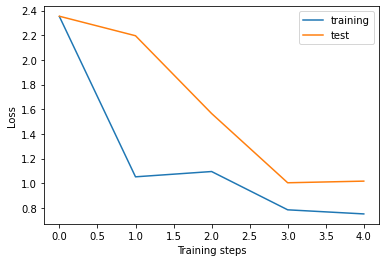

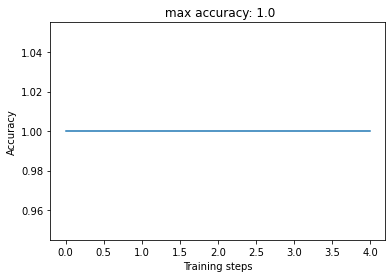

Epoch: __ 4


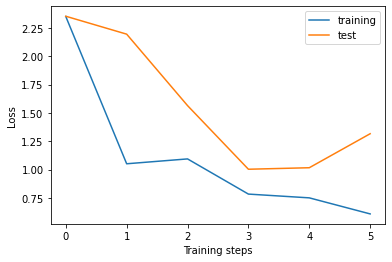

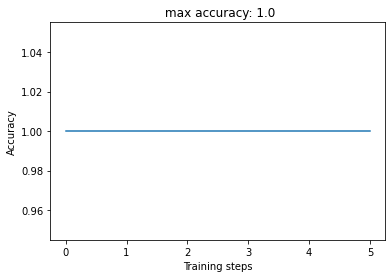

Epoch: __ 5


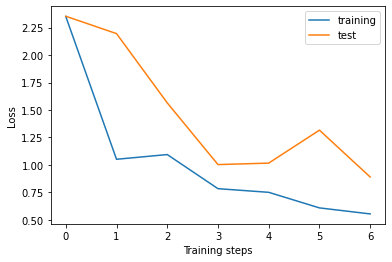

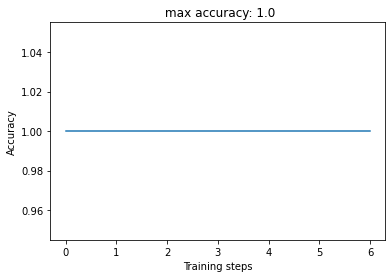

Epoch: __ 6


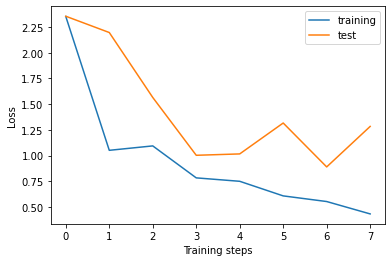

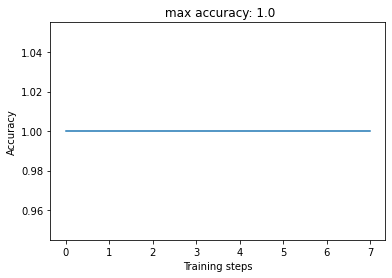

Epoch: __ 7


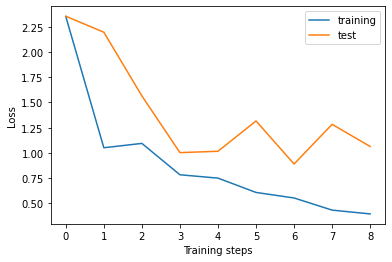

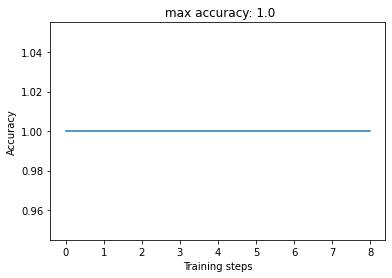

Epoch: __ 8


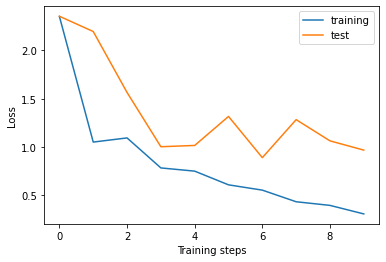

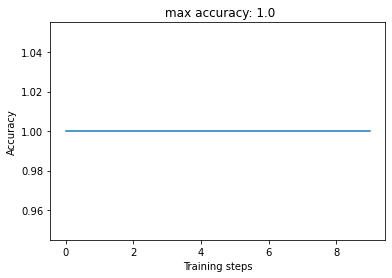

Epoch: __ 9


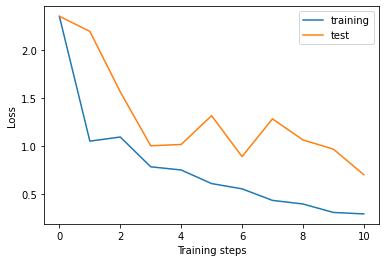

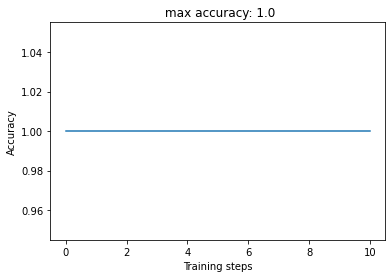

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
running_average_factor = 0

# Initialize the model.
model = ResNet()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
categorical_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, processed_test_data, categorical_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, processed_train_data, categorical_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = processed_train_data.shuffle(buffer_size=128)
    test_dataset = processed_test_data.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, categorical_entropy_loss, optimizer) 
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, categorical_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    visualize(train_losses, test_losses, test_accuracies)

In [ ]:
for (input, target) in processed_train_data:
  print(input)

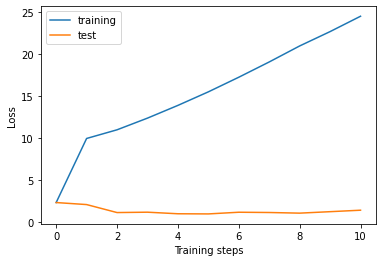

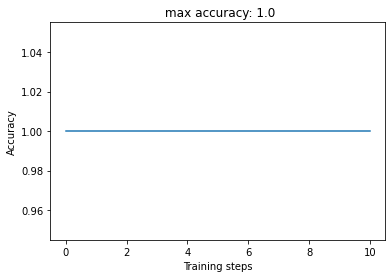